In [20]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [21]:
%cd ../source/

/home/ivan/Projects/pigs-main/source


In [22]:
from PIL import Image
import _pigs as piglib 
import matplotlib.pyplot as plt
import numpy as np
# flattening
from hilbert import decode, encode
# sparse martix handaling
from scipy.sparse import csr_matrix,isspmatrix, lil_matrix 
from scipy.sparse.linalg import spsolve

ModuleNotFoundError: No module named '_pigs'

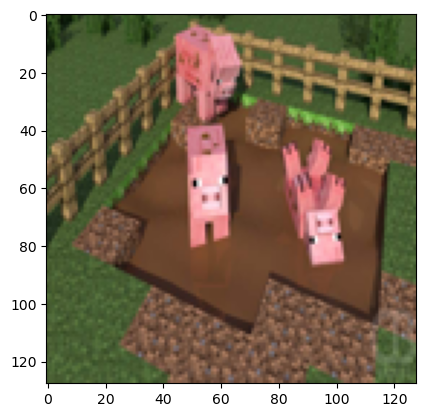

In [4]:
# image = Image.open('../data/test1.png')
image = Image.open('../data/pigs.jpg')
# image = Image.open('pigs.jpg')

m = 7
im_size = (2**m, 2**m)
image_ = image.resize(im_size)
plt.imshow(image_)

In [5]:
'''Hilbert flatttening'''
locs = decode(np.arange(2**m*2**m), 2, m).astype(np.int)

ndarray_image = np.array(image_).astype(int) #/ 255
flatted_image = ndarray_image[locs[:,0], locs[:,1]]
flatted_image.shape

/tmp/ipykernel_198113/3277584618.py:2: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  locs = decode(np.arange(2**m*2**m), 2, m).astype(np.int)


(16384, 3)

In [6]:
'''PIGS gram'''

'PIGS gram'

In [7]:
N = flatted_image.shape[0]
        
R = flatted_image[:,0]
G = flatted_image[:,1]
B = flatted_image[:,2]
x = locs[:,0] / (2*N)
y = locs[:,1] / (2*N)
print(R.shape, G.shape, B.shape, x.shape, y.shape,N)

(16384,) (16384,) (16384,) (16384,) (16384,) 16384


In [8]:
%%time
gram = np.zeros(np.arange(N).sum()) # Upper triangle without diagonal
beta = 1/20

k = 0
for j in range(N-1):
    Ni = N-j-1
    i = j + 1
    
    out = piglib.rgb_pos_kernel(
        R[j].repeat(Ni), G[j].repeat(Ni), B[j].repeat(Ni),
        R[i:],           G[i:],           B[i:],
        x[j].repeat(Ni), y[j].repeat(Ni),
        x[i:],           y[i:],
        beta)
#     print(i,', ',j,' - ',N-i+k - k, gram[k:N-i+k].shape, out.shape)
    gram[k:N-i+k] = out
    k += N-i

AttributeError: module 'pigs' has no attribute 'rgb_pos_kernel'

In [10]:
# plt.plot(gram, 'xk')

In [11]:
gram_matrix = np.zeros((N,N))

k = 0
for j in range(N-1):
    i=j+1
    gram_matrix[j,i:N] = gram[k:N-i+k]
    k += N-i
# del gram}

In [12]:
# full_gram = gram_matrix+gram_matrix.T
# idxs = np.array([(i,i) for i in range(N)])
# full_gram[idxs[:,0], idxs[:,1]] = 1

# plt.imshow(full_gram)
# plt.colorbar()

In [13]:
def get_vertical_index(n):
    # n - side of gram 
    arange = np.arange((n**2-n)//2)

    k = 0
    pre_array = [] 
    for i in range(n-1,-1,-1):
        pre_array += [arange[k:i+k].tolist()]
    #     print(k, i+k, arange[k:i+k])
        k += i

    post_array = []
    for i in range(1, n):
        post_array.append([])
        for j in range(i):
            post_array[-1].append(pre_array[j][i-j-1])
    #         print(i, j, ' - ', pre_array[j][i-j-1])
    #     print()
    return post_array


In [14]:
%%time
n = N
degree = np.zeros(n)

k = 0
v_idxs = get_vertical_index(n)
for j in range(n):
    i=j+1
    
    # horisontal sum
    degree[j] = gram[k:n-i+k].sum()

    # vertical sum
    if j > 0:
        degree[j] += gram[v_idxs[j-1]].sum()
    k+=n-i
    

CPU times: user 44.4 s, sys: 1.16 s, total: 45.5 s
Wall time: 45.5 s


In [15]:
# plt.figure(figsize=(10,5))
# plt.plot(degree, 'ok')


In [16]:
%%time
'''Linear solver'''
root_node = degree.argmax()
# root_node = 6
print('root_node:',root_node)

root_node: 4665
CPU times: user 82 µs, sys: 0 ns, total: 82 µs
Wall time: 79.9 µs


In [ ]:
%%time
sparse_L = lil_matrix (gram_matrix)#+gram_matrix.T) # not L currently
sparse_D = lil_matrix (degree).T
for i in range(N):
    sparse_L[i,i] = sparse_D[i,0]


In [ ]:
del gram_matrix
del degree

In [69]:
# def delete_row_csr(mat, i):
#     if not isinstance(mat, scipy.sparse.csr_matrix):
#         raise ValueError("works only for CSR format -- use .tocsr() first")
#     n = mat.indptr[i+1] - mat.indptr[i]
#     if n > 0:
#         mat.data[mat.indptr[i]:-n] = mat.data[mat.indptr[i+1]:]
#         mat.data = mat.data[:-n]
#         mat.indices[mat.indptr[i]:-n] = mat.indices[mat.indptr[i+1]:]
#         mat.indices = mat.indices[:-n]
#     mat.indptr[i:-1] = mat.indptr[i+1:]
#     mat.indptr[i:] -= n
#     mat.indptr = mat.indptr[:-1]
#     mat._shape = (mat._shape[0]-1, mat._shape[1])

In [70]:
'''drop column and row'''
def rem_row_col(sparse_L, sparse_D):
    cols_to_delete = [root_node]
    all_cols = np.arange(sparse_L.shape[0])
    cols_to_keep = np.where(np.logical_not(np.in1d(all_cols, cols_to_delete)))[0]
    sparse_L = sparse_L[:, cols_to_keep]
    sparse_L = sparse_L[cols_to_keep, :]

    sparse_D = sparse_D[cols_to_keep]
    return sparse_L, sparse_D

sparse_L, sparse_D = rem_row_col(sparse_L, sparse_D)
sparse_L.shape, sparse_D.shape

((16383, 16383), (16383, 1))

In [1]:
%%time
x = spsolve(sparse_L, sparse_D)

NameError: name 'spsolve' is not defined

In [ ]:
plt.plot(x, 'ok')

In [ ]:
'''compute_IR_threshold'''
from pigs import Pigs

In [ ]:
p = Pigs(stop=1e-3, verbose=True, beta=1)

In [ ]:
%%time
threshold, ir, irlist = p.compute_IR_threshold(x, 
                                       gram_matrix+gram_matrix.T, sparse_D, steps=10, usesparse=True)
print(threshold, ir )
# threshold = 0.5
mask = p.generate_mask(flatted_image, x, threshold, root_node)

In [ ]:
irlist = np.array(irlist)
plt.plot(irlist[:,0], irlist[:,1])
# plt.yscale('log')

In [ ]:
msk = np.zeros(im_size)
for i, pos in enumerate(locs):
    msk[pos[0],pos[1]] = mask[i]
    
# plt.imshow(mask.reshape(im_size))
plt.imshow(msk)

In [ ]:
plt.imshow(image_)
